In [1]:
library(RUVnormalizeData)
library(RUVnormalize)

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignette

In [16]:
data('gender', package='RUVnormalizeData')
Y <- t(exprs(gender))
X <- as.numeric(phenoData(gender)$gender == 'M')
X <- X - mean(X)
X <- cbind(X/(sqrt(sum(X^2))))
chip <- annotation(gender)
#labels
lregions <- sapply(rownames(Y),FUN=function(s) {strsplit(s,'_')[[1]][2]})
llabs <- sapply(rownames(Y),FUN=function(s) {strsplit(s,'_')[[1]][3]})
## Dimension of the factors
m <- nrow(Y)
n <- ncol(Y)
p <- ncol(X)
Y <- scale(Y, scale=FALSE) # Center gene expressions
cIdx <- which(featureData(gender)$isNegativeControl) # Negative control genes
## Number of genes kept for clustering, based on their variance
nKeep <- 1260
    
## Prepare plots
annot <- cbind(as.character(sign(X)))
colnames(annot) <- 'gender'
plAnnots <- list('gender'='categorical')
lab.and.region <- apply(rbind(lregions, llabs),2,FUN=function(v){paste(v,collapse='_')})
gender.col <- c('-1' = "deeppink3", '1' = "blue")

## Remove platform effect by centering.
Y[chip=='hgu95a.db',] <- scale(Y[chip=='hgu95a.db',], scale=FALSE)
Y[chip=='hgu95av2.db',] <- scale(Y[chip=='hgu95av2.db',], scale=FALSE)

In [42]:
## Prepare control samples
scIdx <- matrix(-1,84,3)
rny <- rownames(Y)
added <- c()
c <- 0
# Replicates by lab
for(r in 1:(length(rny) - 1)){
    if(r %in% added){next}
    c <- c+1
    scIdx[c,1] <- r
    cc <- 2
    for(rr in seq(along=rny[(r+1):length(rny)])){
        if(all(strsplit(rny[r],'_')[[1]][-3] == strsplit(rny[r+rr],'_')[[1]][-3])){
            scIdx[c,cc] <- r+rr
            cc <- cc+1
            added <- c(added,r+rr)
        }
    }
}
scIdxLab <- scIdx
scIdx <- matrix(-1,84,3)
rny <- rownames(Y)
added <- c()
c <- 0
## Replicates by region
for(r in 1:(length(rny) - 1)){
if(r %in% added)
next
c <- c+1
scIdx[c,1] <- r
cc <- 2
for(rr in seq(along=rny[(r+1):length(rny)])){
if(all(strsplit(rny[r],'_')[[1]][-2] == strsplit(rny[r+rr],'_')[[1]][-2])){
scIdx[c,cc] <- r+rr
cc <- cc+1
added <- c(added,r+rr)
}
}
}
scIdx <- rbind(scIdxLab,scIdx)

In [22]:
## Sort genes by their standard deviation
sdY <- apply(Y, 2, sd)
ssd <- sort(sdY, decreasing=TRUE, index.return=TRUE)$ix
## Cluster the samples
kmres <- kmeans(Y[, ssd[1:nKeep], drop=FALSE], centers=2, nstart=200)
vclust <- kmres$cluster
## Compute the distance between clustering by gender
## and clustering obtained by k-means
uScore <- clScore(vclust,X)

In [23]:
## Centering by region-lab
YmeanCorr <- Y
for(rr in unique(lregions)){
    for(ll in unique(llabs)){
        YmeanCorr[(lregions==rr)&(llabs==ll),] <- scale(YmeanCorr[(lregions==rr)&(llabs==ll),],scale=FALSE)
    }
}
sdY <- apply(YmeanCorr, 2, sd)
ssd <- sort(sdY,decreasing=TRUE,index.return=TRUE)$ix
kmresMC <- kmeans(YmeanCorr[,ssd[1:nKeep],drop=FALSE],centers=2,nstart=200)
vclustMC <- kmresMC$cluster
MCScore <- clScore(vclustMC, X)

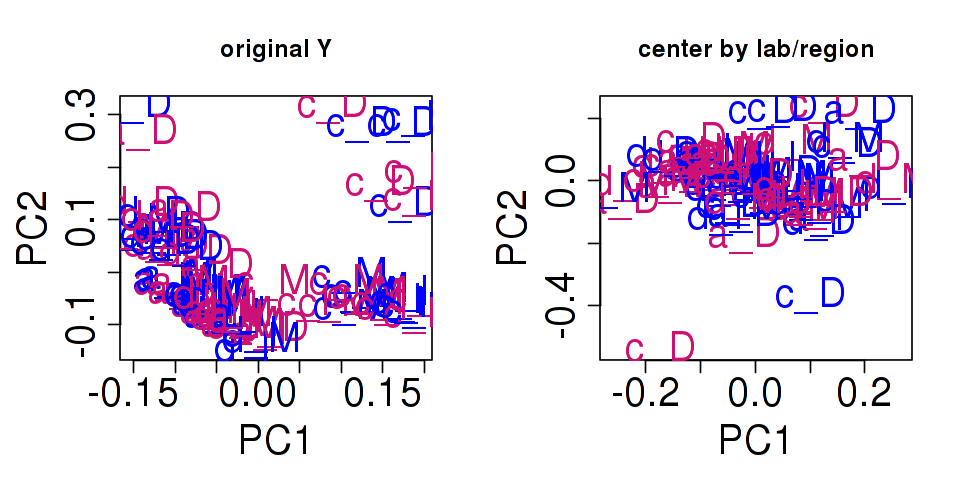

In [32]:
require(repr)
par(mfrow=c(1,2))
options(repr.plot.width=8, repr.plot.height=4)
svdResUncorr <- svdPlot(Y[, ssd[1:nKeep], drop=FALSE],
annot=annot,
labels=lab.and.region,
svdRes=NULL,
plAnnots=plAnnots,
kColors=gender.col, file=NULL)
title(main="original Y")

svdResMC <- svdPlot(YmeanCorr[, ssd[1:nKeep], drop=FALSE],
annot=annot,
labels=lab.and.region,
svdRes=NULL,
plAnnots=plAnnots,
kColors=gender.col, file=NULL)
title(main="center by lab/region")

In [25]:
## Naive RUV-2 no shrinkage
k <- 20
nu <- 0
nsY <- naiveRandRUV(Y, cIdx, nu.coeff=0, k=k)
sdY <- apply(nsY, 2, sd)
ssd <- sort(sdY,decreasing=TRUE,index.return=TRUE)$ix
kmres2ns <- kmeans(nsY[,ssd[1:nKeep],drop=FALSE],centers=2,nstart=200)
vclust2ns <- kmres2ns$cluster
nsScore <- clScore(vclust2ns, X)


In [33]:
## Naive RUV-2 shrinkage
k <- m
nu.coeff <- 1e-3
nY <- naiveRandRUV(Y, cIdx, nu.coeff=nu.coeff, k=k)

sdY <- apply(nY, 2, sd)
ssd <- sort(sdY,decreasing=TRUE,index.return=TRUE)$ix
kmres2 <- kmeans(nY[,ssd[1:nKeep],drop=FALSE],centers=2,nstart=200)
vclust2 <- kmres2$cluster
nScore <- clScore(vclust2,X)


Warning message in naiveRandRUV(Y, cIdx, nu.coeff = nu.coeff, k = k):
“k larger than the rank of Y[, cIdx]. Using k=82 instead”

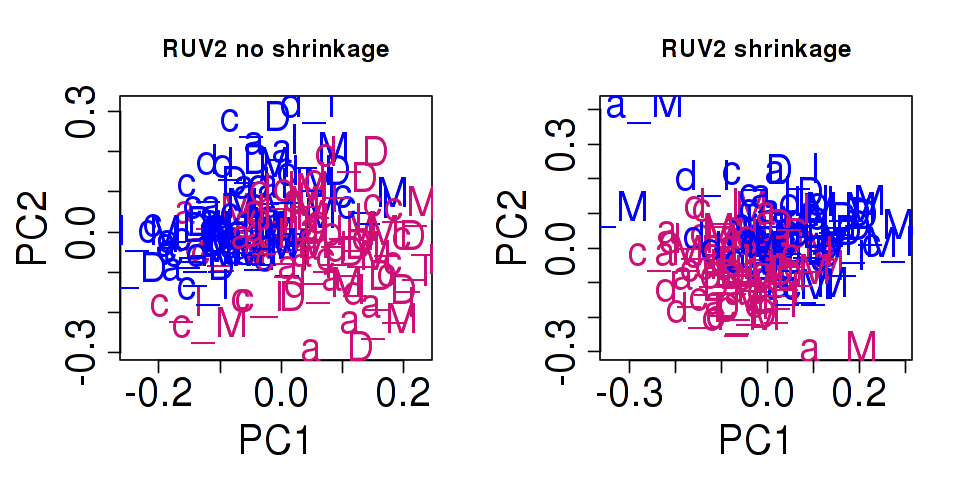

In [40]:
par(mfrow=c(1,2))
options(repr.plot.width=8, repr.plot.height=4)

svdRes2ns <- svdPlot(nsY[, ssd[1:nKeep], drop=FALSE],
annot=annot,
labels=lab.and.region,
svdRes=NULL,
plAnnots=plAnnots,
kColors=gender.col, file=NULL)
title(main="RUV2 no shrinkage")

svdRes2 <- svdPlot(nY[, ssd[1:nKeep], drop=FALSE],
annot=annot,
labels=lab.and.region,
svdRes=NULL,
plAnnots=plAnnots,
kColors=gender.col, file=NULL)
title(main="RUV2 shrinkage")

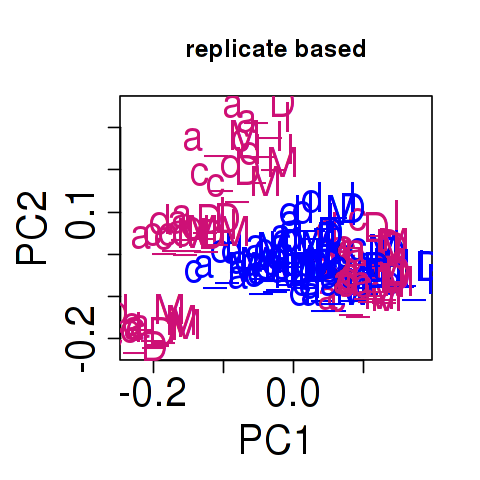

In [43]:
## Replicate-based
options(repr.plot.width=4, repr.plot.height=4)
sRes <- naiveReplicateRUV(Y, cIdx, scIdx, k=20)
sdY <- apply(sRes$cY, 2, sd)
ssd <- sort(sdY,decreasing=TRUE,index.return=TRUE)$ix
kmresRep <- kmeans(sRes$cY[,ssd[1:nKeep],drop=FALSE],centers=2,nstart=200)
vclustRep <- kmresRep$cluster
RepScore <- clScore(vclustRep,X)

svdResRep <- svdPlot(sRes$cY[, ssd[1:nKeep], drop=FALSE],
                     annot=annot,
                     labels=lab.and.region,
                     svdRes=NULL,
                     plAnnots=plAnnots,
                     kColors=gender.col, file=NULL)
title(main="replicate based")

In [45]:
tmp=matrix(c(1,2,1,0,2,3,1,1),4,2)

In [46]:
tmp

1,2
2,3
1,1
0,1


In [48]:
t1=scale(tmp,scale=F)
rbind(scale(t1[1:2,],scale=F),scale(t1[3:4,],scale=F))

-0.5,-0.5
0.5,0.5
0.5,0.0
-0.5,0.0


In [49]:
t2=rbind(scale(tmp[1:2,],scale=F),scale(tmp[3:4,],scale=F))
scale(t2,scale=F)

-0.5,-0.5
0.5,0.5
0.5,0.0
-0.5,0.0
